# Fast Slam

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from matplotlib.animation import FuncAnimation
from util import *

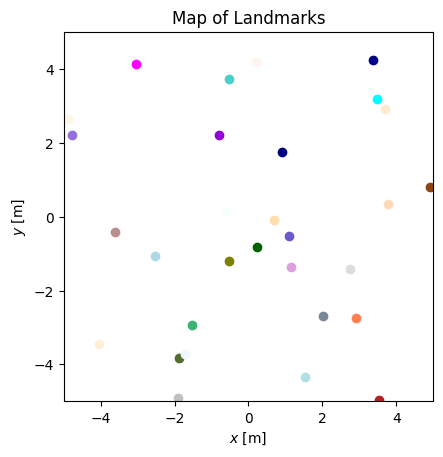

In [10]:
# create map
n_landmarks = 30

x_roi = (-5, 5)
y_roi = (-5, 5)

roi = (x_roi, y_roi)

landmarks = []
for signature in range(n_landmarks):
    landmarks.append(Landmark(Pose.random(roi), signature))

# landmarks.append(Landmark(Pose(2, 0, Angle(0)), 0))
# landmarks.append(Landmark(Pose(3, -1, Angle(30)), 1))
# landmarks.append(Landmark(Pose(3, 1, Angle(-30)), 2))

landmark_map = ParticleMap(landmarks, roi)

#plot map
f, ax = plt.subplots()

ax.set_xlim(x_roi)
ax.set_ylim(y_roi)
ax.set_title("Map of Landmarks")
ax.set_xlabel("$x$ [m]")
ax.set_ylabel("$y$ [m]")
ax.set_aspect('equal', adjustable='box')

landmark_map.draw(ax)

In [11]:
#robot's initial position
robot_pose  = Pose(0, 0, Angle(0))
sensor_pose = Pose(0.5, 0, Angle(0))
th_fov = Angle(60) #[°]
sensor_range = 5 #[m]

#define robot's sensor
sensors = [
    CameraSensor(sensor_pose, th_fov, robot_pose=robot_pose, range=sensor_range)
]

robot = Robot(robot_pose, sensors, landmark_map)

# Aux funcs for init and reset at block begin
def resetRobot():
    robot.updatePosition(robot_pose)

def initializeSLAM():    
    return FastSlam(1, landmark_map)

In [12]:
dt  = 1 #[s]
th1 = Angle(10) #[°]
th2 = Angle(45) #[°]
d   = 0.7 #[m]

u = Odometry(th1, d, th2, dt)

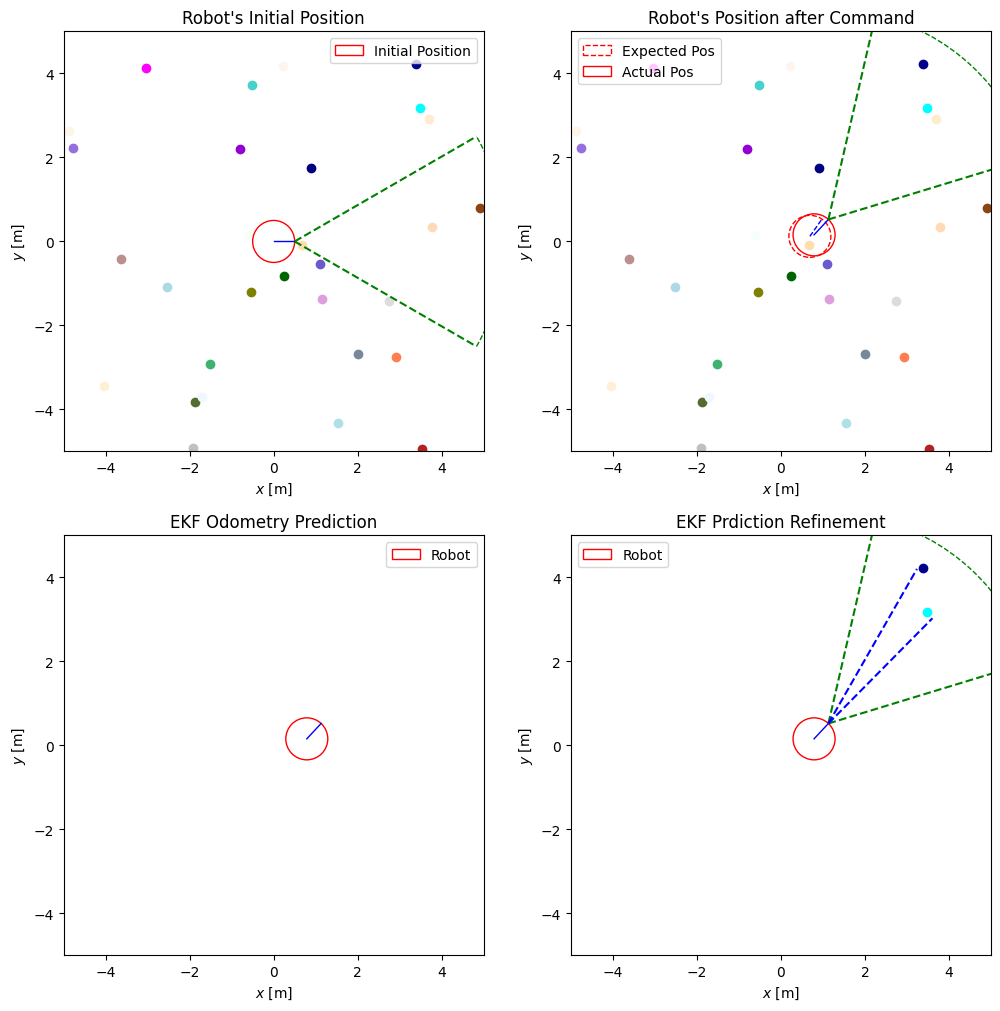

In [13]:
resetRobot()
salm = initializeSLAM()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
### --- AX1
ax1.set_title("Robot's Initial Position")
ax1.set_xlim(x_roi)
ax1.set_ylim(y_roi)
ax1.set_xlabel("$x$ [m]")
ax1.set_ylabel("$y$ [m]")

landmark_map.draw(ax1)
robot.draw(ax1, label="Initial Position")
# salm.draw(ax1, n_sigmas=1)

### --- AX2
ax2.set_title("Robot's Position after Command")
ax2.set_xlim(x_roi)
ax2.set_ylim(y_roi)
ax2.set_xlabel("$x$ [m]")
ax2.set_ylabel("$y$ [m]")

landmark_map.draw(ax2)

robot.applyControl(u, motion_noise=False)
robot.draw(ax2, label="Expected Pos", linestyle='--', draw_sensor=False)

resetRobot()

robot.applyControl(u)
robot.draw(ax2, label="Actual Pos")
### --- AX3
ax3.set_title("EKF Odometry Prediction")
ax3.set_xlim(x_roi)
ax3.set_ylim(y_roi)
ax3.set_xlabel("$x$ [m]")
ax3.set_ylabel("$y$ [m]")

# ekf.predictOdometry(u)
robot.draw(ax3, label="Robot", draw_sensor=False)
# ekf.draw(ax3, n_sigmas=1)

### --- AX4
ax4.set_title("EKF Prdiction Refinement")
ax4.set_xlim(x_roi)
ax4.set_ylim(y_roi)
ax4.set_xlabel("$x$ [m]")
ax4.set_ylabel("$y$ [m]")

sensor_readings = robot.getSensorReadings(detection_noise=True, std_meas_noise=0.1) 
deteced_features = sensor_readings[0][0]
correspondences = sensor_readings[0][1]

# ekf.predictKnownCorrespondence(deteced_features, correspondences)

landmark_map.draw(ax4, correspondences)
robot.draw(ax4, label="Robot", draw_sensor_readings=True)
# ekf.draw(ax4, n_sigmas=1, landmark_map=landmark_map)
